In [1]:
using CairoMakie
using ColorSchemes
using JSON3
using DFTK
using ForwardDiff
using Unitful, UnitfulAtomic

In [2]:
Ecut = 30
kgrid = 4
prefix = joinpath(@__DIR__, "silicon_Ecut$(Ecut)_kgrid$(kgrid)_displacetrue")
scf = Dict(JSON3.read(read(prefix * "_scfres.json", String)))
@assert scf[:Ecut] == Ecut
@assert scf[:kgrid] == "MonkhorstPack([$(kgrid), $(kgrid), $(kgrid)])"
lattice = DFTK.Mat3(scf[:lattice])
positions = map(DFTK.Vec3{Float64}, scf[:atomic_positions])
fft_size = scf[:fft_size]
ρ      = reshape(scf[:y][:ρ], fft_size[1:2]...)
r_cart = reshape(scf[:y][:r], fft_size[1:2]...)
bands = scf[:bands]

JSON3.Object{Base.CodeUnits{UInt8, String}, SubArray{UInt64, 1, Vector{UInt64}, Tuple{UnitRange{Int64}}, true}} with 7 entries:
  :ticks       => {…
  :kdistances  => Union{Float64, Int64}[0, 0.0255135, 0.051027, 0.0765405, 0.10…
  :kbranches   => Array[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  24, 25, 26, 27, 28, …
  :n_bands     => 36
  :n_kcoord    => 109
  :n_spin      => 1
  :eigenvalues => [-0.190347, -0.190073, -0.189253, -0.187887, -0.18598, -0.183…

In [3]:
function parse_derivatives(file)
    data = Dict(JSON3.read(read(file, String)))
    data[:δρ] = reshape(data[:δρ], fft_size[1:2]...)
    data
end
res_xc  = parse_derivatives(prefix * "_derivatives_xc_kappa_plot.json")
res_psp = parse_derivatives(prefix * "_derivatives_psp_cloc1_plot.json")
res_geo = parse_derivatives(prefix * "_derivatives_strain_plot.json")

Dict{Symbol, Any} with 8 entries:
  :δεF             => 0
  :δeigenvalues_bs => Array[[-0.482225, -0.878026, -0.869916, -0.876894, -0.864…
  :δenergies       => [-15.3175, -27.5199, -5.05074, 33.375, 2.52008, 5.16587, …
  :δρ              => [-0.158365 -0.149164 … -0.177008 -0.167965; -0.153678 -0.…
  :δoccupation     => Array[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
  :δeigenvalues    => Array[[-0.482226, -0.878026, -0.869916, -0.876894, -0.864…
  :δforces         => Array[[-0.0450664, -0.00832163, 0.00264283], [-0.158166, …
  :θ               => [0.804, -6.26929, 0.0, 0.25, 0.25, 0.0, 0.25, 0.25, 0.0, …

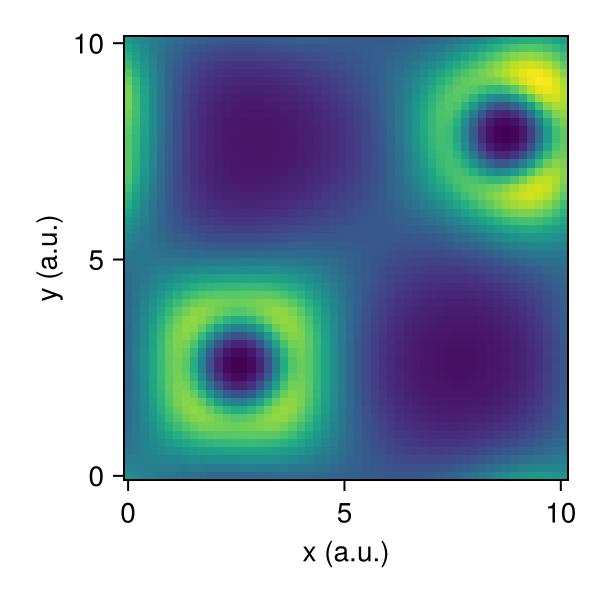

In [4]:
let
    fig = Figure(size=(300,300))
    ax = Makie.Axis(fig[1,1], aspect=AxisAspect(1), xlabel="x (a.u.)", ylabel="y (a.u.)")
    x = getindex.(r_cart[:,1], 1)
    heatmap!(ax, x, x, ρ)
    fig
end

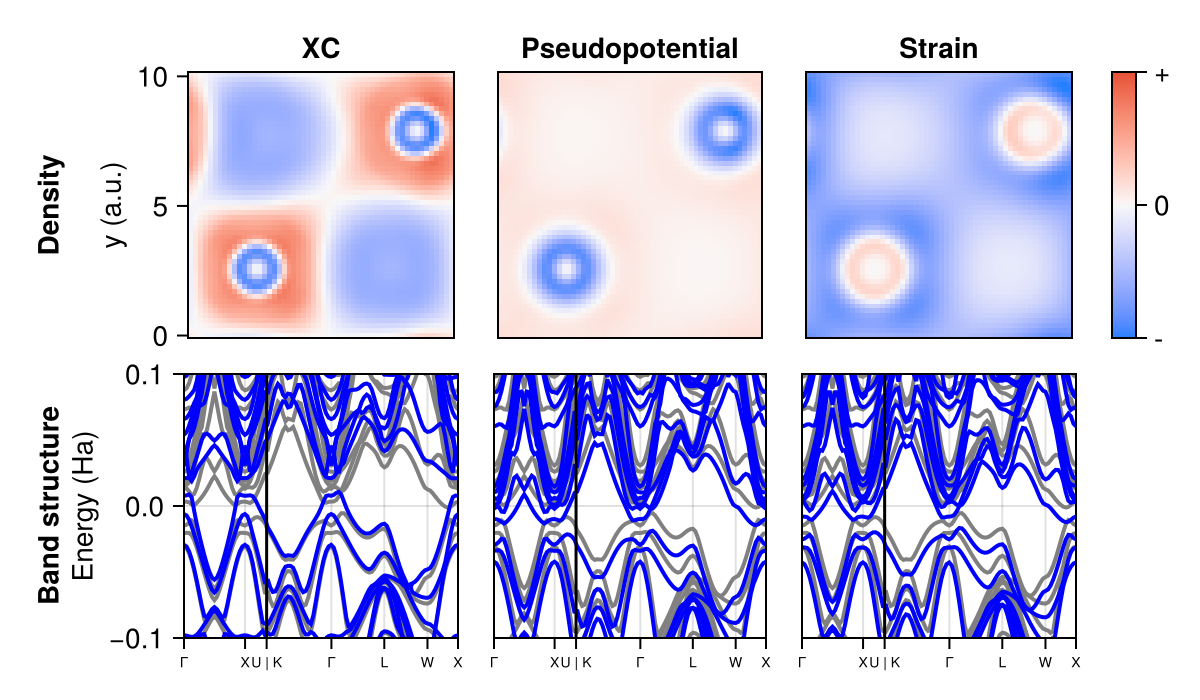

In [5]:
function plot_densities_and_bands(; kwargs...)
    fig = Figure(; kwargs...)

    # Densities
    ax11 = Makie.Axis(fig[1,1], aspect=AxisAspect(1), title="XC", xlabel="x (a.u.)", ylabel="y (a.u.)")
    ax12 = Makie.Axis(fig[1,2], aspect=AxisAspect(1), title="Pseudopotential")
    ax13 = Makie.Axis(fig[1,3], aspect=AxisAspect(1), title="Strain")
    δρ_xc_max  = maximum(abs, res_xc[:δρ])
    δρ_psp_max = maximum(abs, res_psp[:δρ])
    δρ_geo_max = maximum(abs, res_geo[:δρ])
    colormap = :diverging_bwr_55_98_c37_n256
    x = getindex.(r_cart[:,1], 1)
    hm1 = heatmap!(ax11, x, x, res_xc[:δρ];  colormap, colorrange=(-δρ_xc_max, δρ_xc_max))
    hm2 = heatmap!(ax12, x, x, res_psp[:δρ]; colormap, colorrange=(-δρ_psp_max, δρ_psp_max))
    hm3 = heatmap!(ax13, x, x, res_geo[:δρ]; colormap, colorrange=(-δρ_geo_max, δρ_geo_max))
    hidexdecorations!(ax11)
    hidexdecorations!(ax12)
    hidexdecorations!(ax13)
    hideydecorations!(ax12)
    hideydecorations!(ax13)
    Colorbar(fig[1, 4]; colormap, ticks=([0, 0.5, 1], ["-", "0", "+"]))

    # Bands
    xticks = (bands.ticks.distances, bands.ticks.labels)
    xticklabelsize = 7
    xbands = range(0, bands.kdistances[end]; length=length(scf[:y][:eigenvalues_bs]))
    ax21 = Makie.Axis(fig[2,1]; xticks, xticklabelsize, ylabel="Energy (Ha)")
    ax22 = Makie.Axis(fig[2,2]; xticks, xticklabelsize)
    ax23 = Makie.Axis(fig[2,3]; xticks, xticklabelsize)
    for ax in (ax21, ax22, ax23)
        series!(ax, xbands, stack(scf[:y][:eigenvalues_bs]) .- scf[:y][:εF], solid_color=:gray)
        ylims!(ax, (-0.1, 0.1))
        xlims!(ax, (0, bands.kdistances[end]))
    end
    dbands_xc  = stack(scf[:y][:eigenvalues_bs]) + 5.0  * stack(res_xc[:δeigenvalues_bs])  .- (scf[:y][:εF] - res_xc[:δεF])
    dbands_psp = stack(scf[:y][:eigenvalues_bs]) + 3.0  * stack(res_psp[:δeigenvalues_bs]) .- (scf[:y][:εF] - res_psp[:δεF])
    dbands_geo = stack(scf[:y][:eigenvalues_bs]) + 0.01 * stack(res_geo[:δeigenvalues_bs]) .- (scf[:y][:εF] - res_geo[:δεF])
    series!(ax21, xbands, dbands_xc,  solid_color=:blue)
    series!(ax22, xbands, dbands_psp, solid_color=:blue)
    series!(ax23, xbands, dbands_geo, solid_color=:blue)
    for ax in (ax21, ax22, ax23)
        for branch in bands.kbranches[1:end-1]
            vlines!(ax, [bands.kdistances[last(branch)]]; color="black")
        end
    end

    hideydecorations!(ax22, grid=false)
    hideydecorations!(ax23, grid=false)
    # hidexdecorations!(ax22. grid=false)
    # hidexdecorations!(ax23, grid=false)

    # Labels
    Label(fig[1, 1, Left()], "Density", padding = (0, 60, 0, 0), rotation = pi/2, font=:bold)
    Label(fig[2, 1, Left()], "Band structure", padding = (0, 60, 0, 0), rotation = pi/2, font=:bold)
    fig
end

# save(prefix * "_density_bands.pdf", fig)
plot_densities_and_bands(size=(600, 350))

# Combined figure
1. For band structures, visualize results from symmetric atomic positions `displace=false`
2. For densities and forces, visualize results from displaced atomic positions `displace=true`

In [6]:
prefix_sym = joinpath(@__DIR__, "silicon_Ecut$(Ecut)_kgrid$(kgrid)_displacefalse")
scf_sym = Dict(JSON3.read(read(prefix_sym * "_scfres.json", String)))
@assert scf_sym[:Ecut] == Ecut
@assert scf_sym[:kgrid] == "MonkhorstPack([$(kgrid), $(kgrid), $(kgrid)])"
bands = scf_sym[:bands]
fft_size = scf_sym[:fft_size]
function parse_derivatives(file)
    data = Dict(JSON3.read(read(file, String)))
    data[:δρ] = reshape(data[:δρ], fft_size[1:2]...)
    data
end
res_xc_sym  = parse_derivatives(prefix_sym * "_derivatives_xc_kappa_plot.json")
res_psp_sym = parse_derivatives(prefix_sym * "_derivatives_psp_cloc1_plot.json")
res_geo_sym = parse_derivatives(prefix_sym * "_derivatives_strain_plot.json")
dbands_xc  = stack(scf_sym[:y][:eigenvalues_bs]) + 3.0  * stack(res_xc_sym[:δeigenvalues_bs])  .- (scf_sym[:y][:εF] - res_xc_sym[:δεF])
dbands_psp = stack(scf_sym[:y][:eigenvalues_bs]) + 3.0  * stack(res_psp_sym[:δeigenvalues_bs]) .- (scf_sym[:y][:εF] - res_psp_sym[:δεF])
dbands_geo = stack(scf_sym[:y][:eigenvalues_bs]) + 0.01 * stack(res_geo_sym[:δeigenvalues_bs]) .- (scf_sym[:y][:εF] - res_geo_sym[:δεF])

36×47 Matrix{Float64}:
 -0.436172  -0.431345  -0.426021  …  -0.376906   -0.373751   -0.372629
 -0.362811  -0.367216  -0.371079     -0.372182   -0.372518   -0.372629
 -0.362811  -0.367216  -0.371079     -0.372182   -0.372518   -0.372629
 -0.322515  -0.327782  -0.333892     -0.372182   -0.372518   -0.372629
 -0.28598   -0.280588  -0.274595     -0.273301   -0.274188   -0.274488
 -0.240982  -0.235837  -0.23174   …  -0.273301   -0.274188   -0.274488
 -0.240982  -0.235837  -0.23174      -0.273301   -0.274188   -0.274488
 -0.176309  -0.179218  -0.180473     -0.268194   -0.272861   -0.274488
 -0.143199  -0.146068  -0.148705     -0.0745646  -0.0686792  -0.0665206
 -0.143199  -0.146068  -0.148705     -0.0745646  -0.0686792  -0.0665206
  ⋮                               ⋱               ⋮          
  0.183667   0.177018   0.178771      0.103868    0.100716    0.0996495
  0.210113   0.205914   0.202965      0.259979    0.259272    0.259028
  0.245692   0.232673   0.22          0.262696    0.260056  

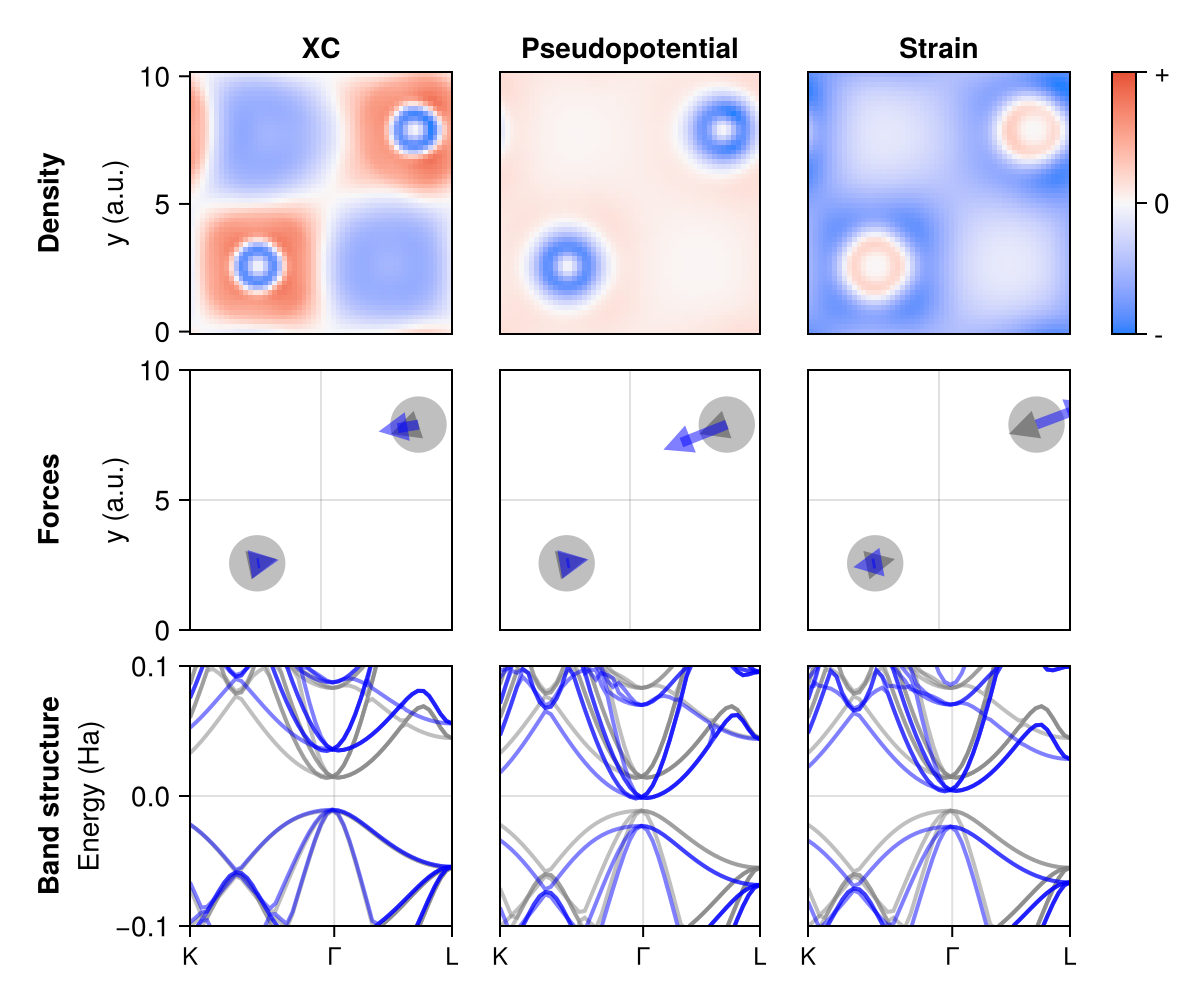

In [8]:
let fig = Figure(size=(600, 500))
    row = 0

    # Densities
    row += 1
    Label(fig[row, 1, Left()], "Density", padding = (0, 60, 0, 0), rotation = pi/2, font=:bold)
    ax11 = Makie.Axis(fig[row,1], aspect=AxisAspect(1), title="XC", xlabel="x (a.u.)", ylabel="y (a.u.)")
    ax12 = Makie.Axis(fig[row,2], aspect=AxisAspect(1), title="Pseudopotential")
    ax13 = Makie.Axis(fig[row,3], aspect=AxisAspect(1), title="Strain")
    δρ_xc_max  = maximum(abs, res_xc[:δρ])
    δρ_psp_max = maximum(abs, res_psp[:δρ])
    δρ_geo_max = maximum(abs, res_geo[:δρ])
    colormap = :diverging_bwr_55_98_c37_n256
    x = getindex.(r_cart[:,1], 1)
    hm1 = heatmap!(ax11, x, x, res_xc[:δρ];  colormap, colorrange=(-δρ_xc_max, δρ_xc_max))
    hm2 = heatmap!(ax12, x, x, res_psp[:δρ]; colormap, colorrange=(-δρ_psp_max, δρ_psp_max))
    hm3 = heatmap!(ax13, x, x, res_geo[:δρ]; colormap, colorrange=(-δρ_geo_max, δρ_geo_max))
    hidexdecorations!(ax11)
    hidexdecorations!(ax12)
    hidexdecorations!(ax13)
    hideydecorations!(ax12)
    hideydecorations!(ax13)
    Colorbar(fig[row, 4]; colormap, ticks=([0, 0.5, 1], ["-", "0", "+"]))

    # Forces
    row += 1
    Label(fig[row, 1, Left()], "Forces", padding = (0, 60, 0, 0), rotation = pi/2, font=:bold)
    axs = [
        Makie.Axis(fig[row,1], aspect=AxisAspect(1), xlabel="x (a.u.)", ylabel="y (a.u.)"),
        Makie.Axis(fig[row,2], aspect=AxisAspect(1)),
        Makie.Axis(fig[row,3], aspect=AxisAspect(1)),
    ]
    for (idx, (α, δforces)) in enumerate([
        (100, res_xc[:δforces]),
        (100, res_psp[:δforces]),
        (1, res_geo[:δforces]),
    ])
        forces_scaled = scf[:y][:forces]
        δforces_scaled = α * δforces
        ax = axs[idx]
        for (x_red, f, δf) in zip(scf[:atomic_positions], forces_scaled, δforces_scaled)
            x = lattice * x_red
            if x[3] == 0
                scatter!(ax, [x[1]], [x[2]], markersize=40, color=:gray, alpha=0.5)
                kwargs = (;
                    arrowsize = 20,
                    lengthscale = 3.0,
                    linewidth = 5,
                    # normalize = true,
                )
                arrows!(ax, [Point2f(x[1:2])], [Vec2f(f[1:2])]; color=:gray, kwargs...)
                arrows!(ax, [Point2f(x[1:2])], [Vec2f((f + δf)[1:2])]; color=(:blue, 0.5), kwargs...)
            end
        end
        limits!(ax, (0, 10), (0, 10))
    end
    hideydecorations!(axs[2], grid=false)
    hideydecorations!(axs[3], grid=false)
    hidexdecorations!(axs[1], grid=false)
    hidexdecorations!(axs[2], grid=false)
    hidexdecorations!(axs[3], grid=false)

    # Bands
    row += 1
    Label(fig[row, 1, Left()], "Band structure", padding = (0, 60, 0, 0), rotation = pi/2, font=:bold)
    xticks = (bands.ticks.distances, bands.ticks.labels)
    xticklabelsize = 12
    ax21 = Makie.Axis(fig[row,1]; aspect=AxisAspect(1), xticks, xticklabelsize, ylabel="Energy (Ha)")
    ax22 = Makie.Axis(fig[row,2]; aspect=AxisAspect(1), xticks, xticklabelsize)
    ax23 = Makie.Axis(fig[row,3]; aspect=AxisAspect(1), xticks, xticklabelsize)
    xbands = range(0, bands.kdistances[end]; length=length(scf_sym[:y][:eigenvalues_bs]))
    for ax in (ax21, ax22, ax23)
        series!(ax, xbands, stack(scf_sym[:y][:eigenvalues_bs]) .- scf_sym[:y][:εF], solid_color=(:gray, 0.5))
        ylims!(ax, (-0.1, 0.1))
        xlims!(ax, (0, bands.kdistances[end]))
    end
    series!(ax22, xbands, dbands_psp, solid_color=(:blue, 0.5))
    series!(ax21, xbands, dbands_xc,  solid_color=(:blue, 0.5))
    series!(ax23, xbands, dbands_geo, solid_color=(:blue, 0.5))
    for ax in (ax21, ax22, ax23)
        for branch in bands.kbranches[1:end-1]
            vlines!(ax, [bands.kdistances[last(branch)]]; color="black")
        end
    end
    hideydecorations!(ax22, grid=false)
    hideydecorations!(ax23, grid=false)

    save("silicon_Ecut30_kgrid4_combined_density_forces_bands.pdf", fig)

    fig
end